# Machine Learning exercise 2: Fruit 360 classification
2021 06 21 Maarten Pennings Created

I followed "Using Python to Implement a Complete Machine Learning Flow", a Doulos Webinar by John Aynsley.

With this notebook, I try to replicate John's second example.

## The project directory

Check my first exercise for details. Basically you need

- Python on your system
- An empty _project_ directory; copy `requirements.txt`, `setup.bat`, `run.bat`, and `fruitfind.ipynb` into it.
- Run `setup.bat` to create a virtual Python environment `env` in the project dictctory.
- Note that several packages will be installed (including Jupyter), as listed in `requirements.txt`.
- Run `run.bat` to run the Jupyter server and client (web page in you browser).
- Open this file (`fruitfind.ipynb`).

## Getting the data

Download [A dataset with 90380 images of 131 fruits and vegetables](https://www.kaggle.com/moltean/fruits) from Kaggle. 
You get a zip file of 760 MB. Unzip it in the project directory, so that it looks as follows

```text
+---env
|   +---Lib
|   +---Scripts
|   :
+---fruits-360
|   +---readme.md
|   +---papers
|   +---Training
|   |   +---Apple Braeburn
|   |   :   +--- 0_100.jpg
|   |   :   +--- 1_100.jpg
|   |   :   :
|   |   +---Watermelon
|   +---Test
|       +---Apple Braeburn
|       :   +--- 3_100.jpg
|       :   +--- 4_100.jpg
|       :   :
|       +---Watermelon
+---fruitfind.ipynb
+---requirements.txt
+---run.bat
+---setup.bat
```

As the `readme.md` in `fruits-360` explains

 - There are 90483 images in total.
 - The `Training` directory has 67692 images.
 - The `Test` directory has 22688 images.
 - There are 131 classes (of fruits and vegetables).
 - Both `Training` and `Test` contain 131 directories, one for each class, with several jpg inside.
 - The images are 100×100 pixels in color.



Let's first try to see if we can plot an image: `fruits-360\Training\Apple Braeburn\0_100.jpg`. 

Note that we use a _raw_ string so that we do not have to escape the back-slashes. We convert the image to a numpy array, since matplotlib likes that as input.

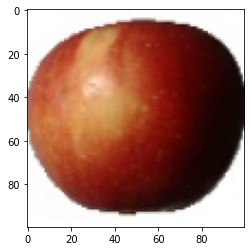

In [18]:
import imageio
im = imageio.imread( r"fruits-360\Training\Apple Braeburn\0_100.jpg")

import numpy as np
im = np.array(im)

import matplotlib.pyplot as plt
plt.imshow(im);

Note that the image is 100×100 pixels, just as the readme promissed.

## Reading all data

The images are spread over directories, so in order to read all images, we use the os module to traverse all directories.

First we make a list of all categories.

In [22]:
import os
os.listdir("fruits-360\Training")

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Apricot',
 'Avocado',
 'Avocado ripe',
 'Banana',
 'Banana Lady Finger',
 'Banana Red',
 'Beetroot',
 'Blueberry',
 'Cactus fruit',
 'Cantaloupe 1',
 'Cantaloupe 2',
 'Carambula',
 'Cauliflower',
 'Cherry 1',
 'Cherry 2',
 'Cherry Rainier',
 'Cherry Wax Black',
 'Cherry Wax Red',
 'Cherry Wax Yellow',
 'Chestnut',
 'Clementine',
 'Cocos',
 'Corn',
 'Corn Husk',
 'Cucumber Ripe',
 'Cucumber Ripe 2',
 'Dates',
 'Eggplant',
 'Fig',
 'Ginger Root',
 'Granadilla',
 'Grape Blue',
 'Grape Pink',
 'Grape White',
 'Grape White 2',
 'Grape White 3',
 'Grape White 4',
 'Grapefruit Pink',
 'Grapefruit White',
 'Guava',
 'Hazelnut',
 'Huckleberry',
 'Kaki',
 'Kiwi',
 'Kohlrabi',
 'Kumquats',
 'Lemon',
 'Lemon Meyer',
 'Limes',
 'Lychee',
 'M

Note that the `\` in the code is frowned upon, that is Windows specific. The `path.join` abstracts that away.

In [34]:
training_path = os.path.join("fruits-360","Training")
categories = os.listdir(training_path)
print( f"'{training_path}' has '{categories[0]}', '{categories[1]}', '{categories[2]}', ..." )

'fruits-360\Training' has 'Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', ...


Let's check that the test directory has the same categories.

In [47]:
testing_path = os.path.join("fruits-360","Test")
print( categories == os.listdir(testing_path) )

True


Following the convention `x` will contain the inputs (all training images), and `y` the outputs (the fruit category).

Please note that the code below will read 470 MB of Training data. That takes some time: 217 seconds on my PC.

In [49]:
x = []
y = []
for ix,category in enumerate(categories) :
    category_path = os.path.join(training_path,category)
    for file_name in os.listdir(category_path) :
        file_path = os.path.join(category_path,file_name)
        image = imageio.imread( file_path )
        x.append(image)
        y.append(ix)

24.7 s ± 127 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's check the array shape. According to the documentation, we should have 67692 images, of 100 by 100 pixels, each 3 color channels (red, gree, blue).

In [72]:
x = np.array(x)
print(x.shape)

(67692, 100, 100, 3)


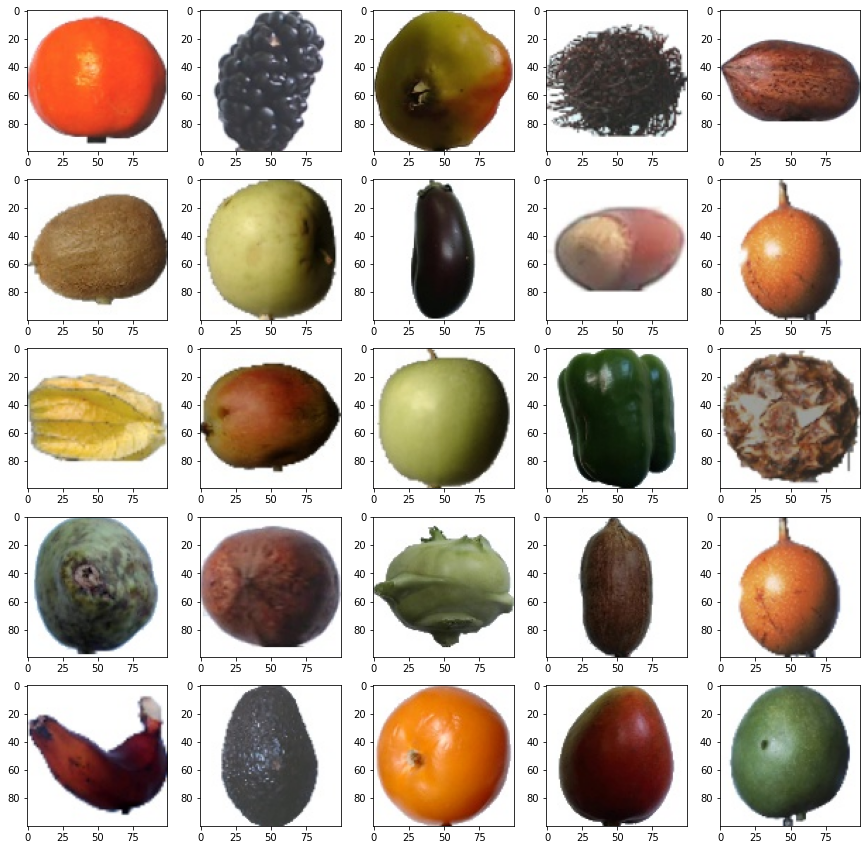

In [73]:
import random
n = 5
fig = plt.figure(n*n,figsize=(15,15))
for yy in range(n):
    for xx in range(n):
        ix = random.randrange(0, len(x))
        fig.add_subplot(n,n,yy*n+xx+1)
        plt.imshow(x[ix])


Recall that each pixel is stored as three values. Let us look at the upper left pixel `[0,0]` of image 0. We see that this is an array of three values (practically white), each byte. And indeed the full range of byte is used (0..255).

In [76]:
x[0][0,0]

array([254, 255, 255], dtype=uint8)

In [79]:
x.min(), x.max()

(0, 255)

The `max` above if over all color channels. I hoped that e.g. blue would not be so much present. I checked that with a histogram. I sliced over all images, and all coordinates, but only channel 2. This converts (67692,100,100,3) to (67692,100,100). Then I linearized that by passing -1 as new shape.

At first I was surprised there is so much blue. Then I realized that white also contains blue, and indeed there are over 100 million pixels with bue at 255.

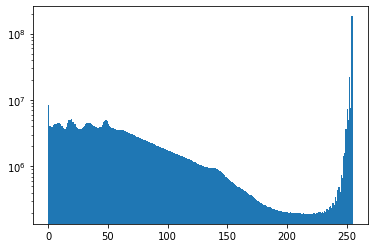

In [91]:
plt.hist(x[:,:,:,2].reshape(-1),bins=256,log=True);

(end)